In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

## Exploring the Dataset

In [3]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 5, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (500, 299, 299, 3)
test_images:      (300, 299, 299, 3)


In [4]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
<start>
aaaand
<end>
<pad>
aaannd
aaaaand
aaaaaand
aaand
aaaaaaand
flappy
annddd
deathclaws
aaaaanddd
aaaaaaaaand
aaaaaaaaaaand
aaaaaaaand
waaay
inlove
nvm
guyz
roofie
faps
resturant
upvotes
downvotes
pokedex
upvote
hahah
proffesor
beiber
shits
shemale
skyrim
whaat
yeahhh
memegenerator
yesssssss
chatango
permisson
runscape
pornhub
meatspin
finnaly
omfg
wasent
cuck
christm
scho
challeng
anons
rubix
shabbirv
apears
butthurt
alergy
shitstorm
apocalipse
yourselfs
hypobromite
nabro
pawsitive
killstreak
fuuu
ffffuuuu
fffffffuuuuu
replys
fucktard
ermahgerd
roblox
friendzone
shouldnt
ahahahaha
handjob
srsly
bruhhh
fortnite
mutherfucker
bonasera
capish
girlies
snorlax
caterpie
wailord
doduo
koffing
diglett
fornite
dumbasses
lololol
shitloads
creampie
goooo
skyped
prety
unfollowed
dizer
jogar
reposts
dogshit
pssh
mckayla
obito
dafuq
gaaaaaaay
akward
cums
friendzoned
mastrubating
fapping
boyscouts
bday
monkies
winrar
safesearch
chiken
hahahaha
selfies
drunked
titties
sh

In [5]:
embedding_matrix.shape

(9954, 300)

Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed sep aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win sep aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love sep aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> poops reaches for toilet paper sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


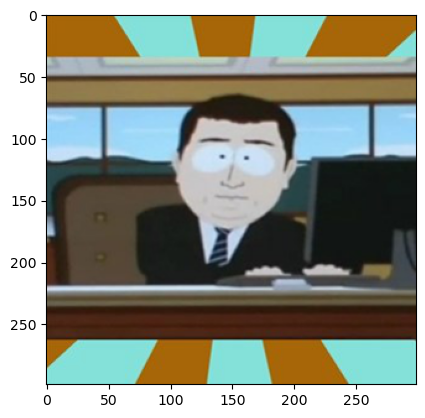

Caption 1: <start> had good idea for meme sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had my chance to hit it sep aaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> wild abra appears sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> just got paid sep and its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had really great dream last night sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


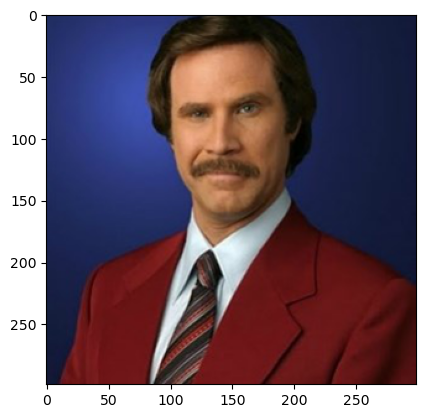

Caption 1: <start> toronto has lead sep aaaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> just found out about flappy bird sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> here is obama with your tax payers money sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ve got good idea sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had some hope sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


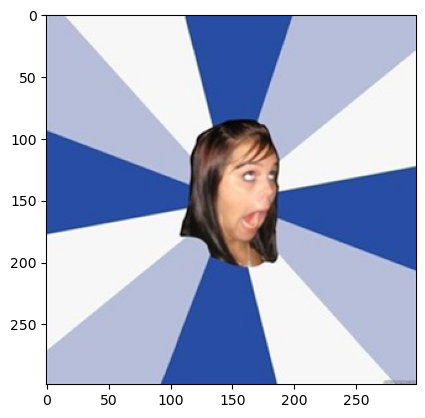

Caption 1: <start> october is here sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> the mets have the lead going into the inning sep aaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> just got my paycheck sep aaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ll just load save sep annddd surrounded by deathclaws <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> moment ago felt compelled to do something nice for you sep and it gone <end> <pad> <pad> <pad> <pad> <pad>


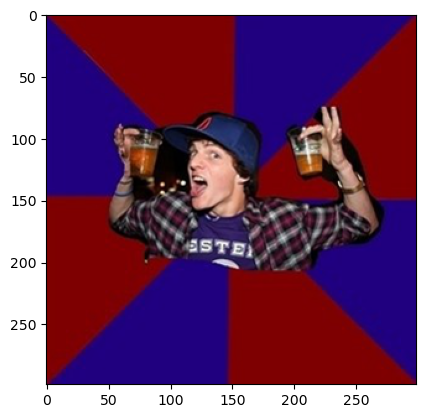

Caption 1: <start> here some nice really warm weather sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> you made another religious post sep aaaaaand you re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> ll just look up my respect for you sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> okay just go inside go to the deli get the meat and cheese sep aaannd forgot my wallet <end> <pad>
Caption 5: <start> twinkies sep aaaand they re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


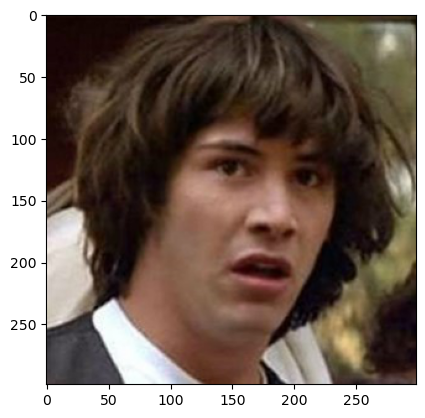

In [6]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 5 + j]]))
    plt.imshow(train_images[i * 5])
    plt.show()

### Running your RNN model

Depending on your use cases, you may choose to structure your model in a variety of ways. In contrast to previous assignments, this one is intended to mimic a lot of modern research-oriented repositories you might find in the wild. Specifically: **Instead of providing easy-to-use APIs for experimenters, they rigidify their implementation to make tests replicable.** Specifically, they may provide a command-line interface and define testing/training procedures which log results. 

(I mean, ideally you can make a flexible API and allow for both ease of extension and examples to demonstrate how your results were gathered, but sometimes researchers only have so much time...)

Once you have filled in the `model.py` components and the `RNNDecoder` of the `decoder.py` file, run this block to train your RNN model. As you can see, the hyperparamets default to the ones you use in `assignment.py`'s argparse specification, but feel free to change any of them to try to improve your model. 




In [7]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 2 --chkpt_path ../rnn_model
## if using colab, you may need to do something like the following or might need to %cd into the directory of interest first...

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.191	 acc: 0.184	 perp: 488.518
[Valid 2/30]	 loss=6.018	 acc: 0.186	 perp: 410.809
[Valid 3/30]	 loss=6.017	 acc: 0.196	 perp: 410.434
[Valid 4/30]	 loss=6.172	 acc: 0.198	 perp: 479.089
[Valid 5/30]	 loss=6.167	 acc: 0.202	 perp: 476.728
[Valid 6/30]	 loss=6.153	 acc: 0.208	 perp: 469.899
[Valid 7/30]	 loss=6.144	 acc: 0.206	 perp: 465.722
[Valid 8/30]	 loss=6.129	 acc: 0.214	 perp: 459.130
[Valid 9/30]	 loss=6.135	 acc: 0.210	 perp: 461.932
[Valid 10/30]	 loss=6.152	 acc: 0.208	 perp: 469.752
[Valid 11/30]	 loss=6.138	 acc: 0.202	 perp: 462.974
[Valid 12/30]	 loss=6.083	 acc: 0.199	 perp: 438.186
[Valid 13/30]	 loss=6.094	 acc: 0.198	 perp: 443.329
[Valid 14/30]	 loss=6.140	 acc: 0.198	 perp: 463.942
[Valid 15/30]	 loss=6.119	 acc: 0.197	 perp: 454.275
[Valid 16/30]	 loss=6.110	 acc: 0.196	 perp: 450.342
[Valid 17/30]	 loss=6.100	 acc: 0.193	 perp: 445.765
[Valid 18/30]	 loss=6.100	 acc: 0.196	 perp: 4

2024-05-02 11:33:18.096898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-02 11:34:13.623932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Running your Transformer model

Once you have completed the `transformer.py` file, run this block to train your transformer based model. Note that running with the `both` task will both train, save, and test your model in one go.

In [8]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.328	 acc: 0.166	 perp: 559.911
[Valid 2/30]	 loss=6.192	 acc: 0.165	 perp: 488.669
[Valid 3/30]	 loss=6.167	 acc: 0.176	 perp: 476.650
[Valid 4/30]	 loss=6.297	 acc: 0.174	 perp: 543.052
[Valid 5/30]	 loss=6.293	 acc: 0.178	 perp: 540.650
[Valid 6/30]	 loss=6.282	 acc: 0.180	 perp: 534.833
[Valid 7/30]	 loss=6.267	 acc: 0.180	 perp: 526.982
[Valid 8/30]	 loss=6.264	 acc: 0.185	 perp: 525.185
[Valid 9/30]	 loss=6.273	 acc: 0.183	 perp: 529.988
[Valid 10/30]	 loss=6.288	 acc: 0.182	 perp: 538.082
[Valid 11/30]	 loss=6.277	 acc: 0.178	 perp: 532.370
[Valid 12/30]	 loss=6.224	 acc: 0.175	 perp: 504.761
[Valid 13/30]	 loss=6.234	 acc: 0.175	 perp: 509.933
[Valid 14/30]	 loss=6.273	 acc: 0.175	 perp: 529.970
[Valid 15/30]	 loss=6.252	 acc: 0.174	 perp: 519.228
[Valid 16/30]	 loss=6.243	 acc: 0.173	 perp: 514.289
[Valid 17/30]	 loss=6.231	 acc: 0.171	 perp: 508.495
[Valid 18/30]	 loss=6.231	 acc: 0.173	 perp: 5

2024-05-02 10:29:03.602725: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-02 10:30:00.849794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.





## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [8]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)





Model loaded from '../transform_model'
Model loaded from '../rnn_model'


In [9]:
rnn_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_decoder (RNNDecoder)    multiple                  7318254   
                                                                 
Total params: 7318254 (27.92 MB)
Trainable params: 7318254 (27.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7408554   
 formerDecoder)                                                  
                                                                 
Total params: 7408554 (28.26 MB)
Trainable params: 7408554 (28.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


In [11]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

## Generating Sentences for Training Data 

C1: slipped her roofie sep accidently drinks her beer
C2: lost my virginity sep while listening to dave matthews band
C3: just holding these sep until the cool kids get back
C4: dude if you mix with sep you get
C5: shot of vodka sep wasted
RNN: you re the sep you have the
TRA: sniffs sharpie sep can drink


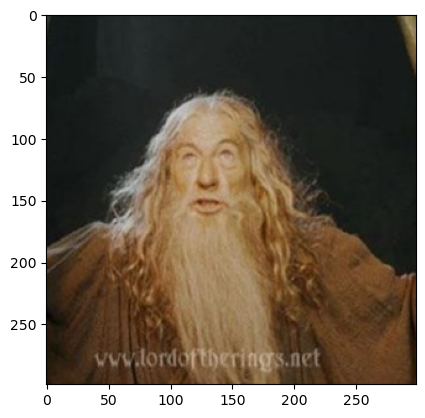

C1: munch out on cereal sep put milk in cupboard
C2: goes to kitchen for cereal sep leaves with pepsi crackers slice of pizza banana and cheetos
C3: giraffe giraffe giraffe giraffe giraffe giraffe giraffe sep doesn sound like word anymore
C4: breakfast for dinner sep awwww yeahhh
C5: how high would you be sep if you didn know how high you are
RNN: you you re the sep you have the
TRA: how high sep awwww sep awwww sep awwww sep awwww sep awwww sep awwww sep awwww


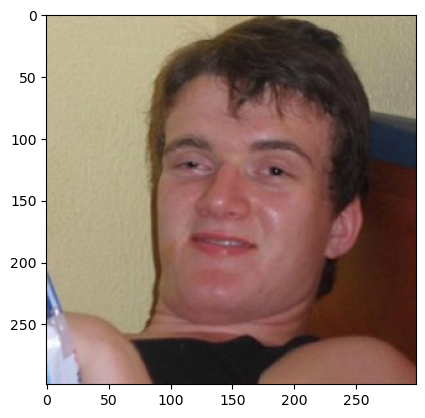

C1: going to starbucks with my friends sep photos of latte
C2: realizes whitney houston died sep become fan on facebook
C3: been dating one day sep omg im so inlove with you
C4: omg hate those immigrants learn english sep their all stupid
C5: shares kony video sep fixed africa
RNN: you re the sep you have the
TRA: omg sep omg sep omg sep omg sep omg sep omg sep omg sep omg sep omg sep


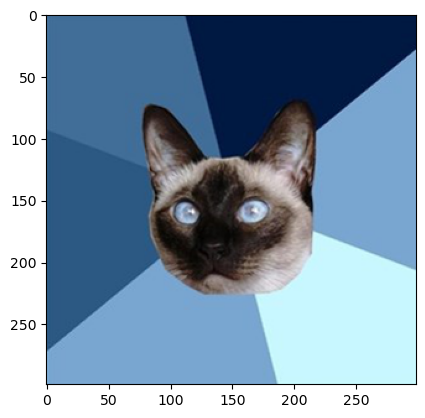

C1: your ex runs into you and your new girlfriend sep you have no power here
C2: your kisses have no power here sep ve got oline
C3: when your old boss tells you to do something sep you have no power here
C4: mods ha sep you have no power here
C5: arguing with woman sep you have no power here
RNN: you re the sep you have the
TRA: you have no power here sep you have no power here


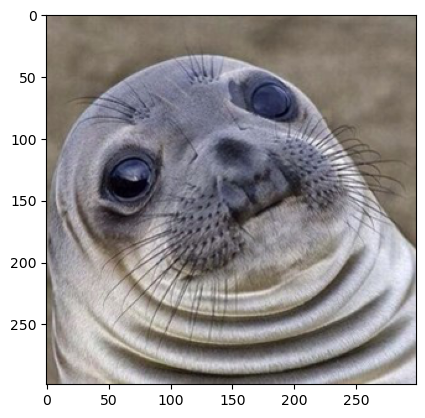

C1: ve told you allah sep your people is just to stupid
C2: your scam sep has no power here
C3: steam sales sep you have no power here
C4: french kissing years old in an islamic country sep you have no power here
C5: obama on ukraine sep you have no power here
RNN: you re the sep you have the
TRA: you have no power here sep you have no power here


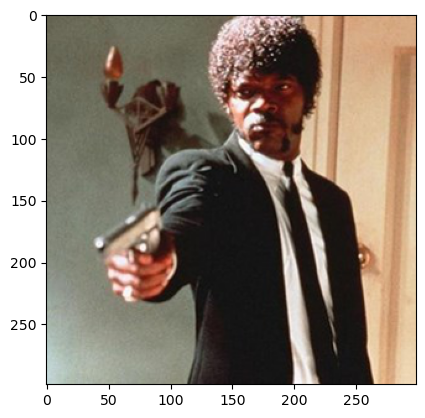

C1: your freedom of speech sep has no power here
C2: royal air force sep you have no power here
C3: at the mall your ex runs into you with your current gf sep ha ha ha you have no
C4: your legal mumbo jumbo sep has no power here
C5: hot married women sep you have no power here
RNN: you re the sep you have the
TRA: you have no power here sep you have no power here


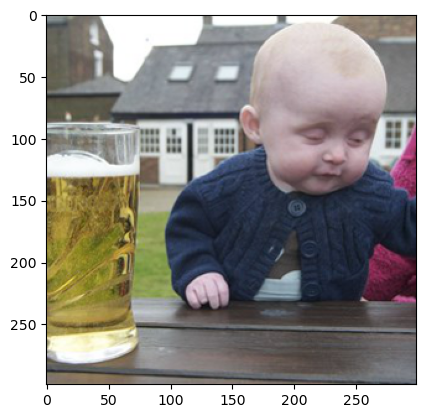

C1: toronto has lead sep aaaaaaand it gone
C2: just found out about flappy bird sep aaaand it gone
C3: here is obama with your tax payers money sep aaaaand it gone
C4: ve got good idea sep aaaaand it gone
C5: had some hope sep aaaand it gone
RNN: you you re the sep you re the
TRA: just got an idea sep aaaaand it gone


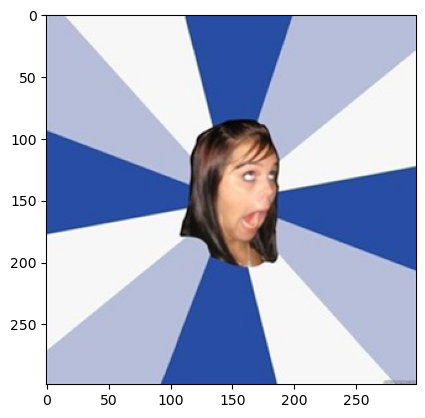

C1: october is here sep aaaand it gone
C2: the mets have the lead going into the inning sep aaaaaand it gone
C3: just got my paycheck sep aaaand its gone
C4: ll just load save sep annddd surrounded by deathclaws
C5: moment ago felt compelled to do something nice for you sep and it gone
RNN: you you re the sep you have the
TRA: just got an idea sep aaaaand it gone


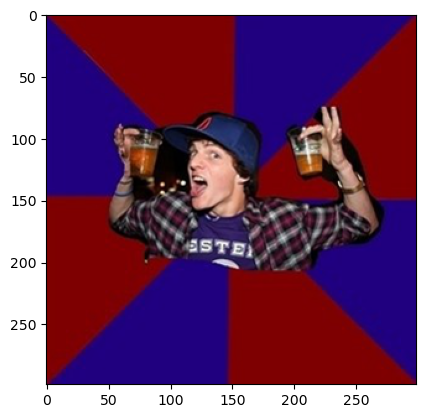

C1: to the people who say white people can never experience oppression or racism sep here my gift
C2: apple wanted me to work for them sep responded them with this
C3: nvidia sep pull my finger
C4: you know what you can do sep with that pull request
C5: when customer says just have quick question sep and asks it minutes before closing
RNN: you you re the sep you have the
TRA: fuck you sep you


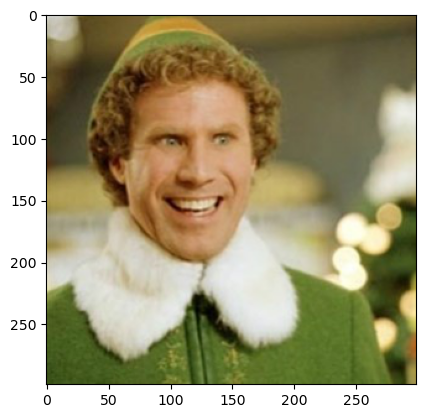

C1: product of canada sep may contain defects
C2: is supposedly sep still looks
C3: gets caught sucking dick sep doesn deny it
C4: receives speeding ticket sep his car didn move but he drove his bf cock fast in the backseat
C5: gets caught red handed sucking cock sep keeps sucking cock
RNN: sep you have the the
TRA: what if you sep it


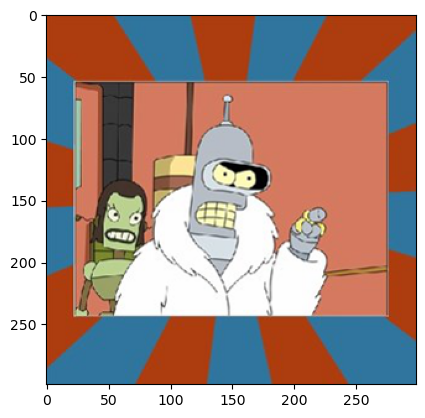

In [12]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('RNN:', gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

### Trying out on things in testing set!

In [13]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 3000, 50))), 10, replace=False)
rnn_captions = []
tra_captions = []
for i in indices:
    curr_image_feat = test_img_feats[i]
    #rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    #tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    #rnn_captions.append(rnn_caption)
    #tra_captions.append(tra_caption)
    #plt.imshow(curr_image)
    #plt.show()
    #output = rnn_imcap.get_offensive_score("Here")
    text, offensive_score = rnn_imcap.get_filtered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    print(text, offensive_score)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [17]:
from filter_utils import print_captions_and_label
print_captions_and_label(tra_captions, "offensive")

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.
